<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - Unveiling Chronic Disease in Singaporean Lifestyle

> Authors: Chung Yau, Gilbert, Han Kiong, Zheng Gang
---

**Problem Statement:**  
In Singapore, the increasing prevalence of chronic diseases presents a pressing public health concern, underscoring the need for proactive intervention strategies. 

How can we identify individuals at high risk for chronic diseases based on their behavioral habits? By doing so, we can enable early detection and provide recommendations, fostering a proactive approach to preventing various chronic diseases.

  
**Target Audience:**  
Product team in Synapxe, in preparation for Healthier SG 2025 roadmap workshop. 

These are the notebooks for this project:  
 1. [`01_Data_Collection_Food`](01_Data_Collection.ipynb)
 2. [`02_Data_Preprocessing`](02_Data_Preprocessing.ipynb)
 3. [`03_FeatureEngineering_and_EDA`](03_FeatureEngineering_and_EDA.ipynb)
 4. [`04_Data_Modelling`](04_Data_Modelling.ipynb)
 5. [`05_Hyperparameter_Model Fitting_Evaluation`](05_Hyperparameter_Model%20Fitting_Evaluation.ipynb)
 6. [`05a_Model_Pickling`](05a_Model_Pickling.ipynb)
 7. [`06_Implementation_FoodRecommender`](06_Implementation_FoodRecommender.ipynb)

 ---
# **This Notebook: 06_Implementation_FoodRecommender**
This notebook will be solely on the building of the dish recommender. For each user profile in file `category_diet.csv`, we have a predefined nutrition profile of a desired meal that we will use cosine similarity to get the top 5 most similar food.

The categories and recommended nutrition food profiles are derived from the below webpages:
- [HealthHub Dietary Allowances](https://www.healthhub.sg/live-healthy/recommended_dietary_allowances)
- [HealthHub Calorie Calculator](https://www.healthhub.sg/programmes/nutrition-hub/tools-and-resources#calorie-calculator)
- [HealthHub Protein Importance](https://www.healthhub.sg/live-healthy/why_protein_is_important#:~:text=For%20average%20Singaporean%20adults%20aged,1.2g%2Fkg%20bodyweight%20instead.)
- [HealthHub Getting the Fats Right](https://www.healthhub.sg/live-healthy/getting%20the%20fats%20right#:~:text=Fat%20should%20make%20up%20about,if%20one%20is%20not%20mindful.)
- [USDA National Agricultural Library](https://www.nal.usda.gov/programs/fnic#:~:text=How%20many%20calories%20are%20in,Facts%20label%20on%20food%20packages.)
- [Centrum Singapore - Healthy Diet](https://www.centrum.sg/expert-corner/health-blog/healthy-diet-do-you-follow-dietary-guidelines/)
- [HPB National Nutrition Survey 2022 Report](https://www.hpb.gov.sg/docs/default-source/pdf/nns-2022-report.pdf)
- [Signos - Sugar Intake for Type 2 Diabetics](https://www.signos.com/blog/how-much-sugar-should-a-type-2-diabetic-have-a-day)
- [HealthXchange - Diabetes Glycaemic Index](https://www.healthxchange.sg/diabetes/essential-guide-diabetes/diabetes-glycaemic-index-know)
- [NDTV Food - Dividing Calories in Each Meal](https://food.ndtv.com/food-drinks/how-to-divide-calories-in-each-meal-we-help-deconstruct-it-for-you-1750305#:~:text=NIN%20recommends%20dividing%20equal%20portion,the%20total%20calories%20you%20consume.)
- [Statistics Canada - Sodium Intake](https://www150.statcan.gc.ca/n1/pub/82-003-x/2006004/article/sodium/4148995-eng.htm)

The nutritional profile of the dishes are labelled into their cuisine types manually, and the nutrition values can either be found in the below link in [ObservableHQ - SG Hawker Food Nutrition](https://observablehq.com/@yizhe-ang/sg-hawker-food-nutrition) or manually scrapped as per `01_Data_Collection.ipynb` from [HPB website](https://focos.hpb.gov.sg/eservices/ENCF/)

---

### **Import Libraries**

Imports essential libraries for data manipulation, preprocessing, visualization, and similarity calculation. Specifically, Pandas for data manipulation, NumPy for numerical operations, scikit-learn's StandardScaler for feature standardization, Matplotlib and Seaborn for visualization, and scikit-learn's cosine_similarity function for calculating cosine similarity between vectors.   
These libraries enable tasks such as data manipulation, preprocessing, visualization of data distributions, and computation of similarity scores, which are commonly used in data analysis and machine learning tasks, including recommendation systems.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

Define `mean_center_rows` function aims to normalize data by removing row-wise means.   
This preprocessing technique is crucial in recommender systems, ensuring fairness and comparability across users or items.   
By subtracting each row's mean from its values, bias is minimized, allowing the system to focus on relative differences in item ratings or relative nutritional proportion for the case of our recommender.   
The provided code computes row-wise means, subtracts them from respective rows, and fills missing values with zeros, resulting in a mean-centered dataset conducive to accurate recommendations.

In [2]:
def mean_center_rows(data):
    # Create a copy of the data so we don't overwrite original
    data = data.copy()
    
    data['avg_value'] = data.mean(axis=1)
    
    # Subtract the original values with calculated average
    for col in data.columns:
        data[col] = data[col] - data['avg_value']
        
    # Drop the user_avg_rating column
    data = data.drop(columns=['avg_value'])
    
    # Fill NA
    data = data.fillna(0)
    
    return data

Function to perform user_profile mapping. The user profile consist of the following concatenated into a single string, as a lookup value in the user dietary category.

Age group
Gender
Physical Activities hours per week
Chronic Disease Health Risk ( 0: no risk, 1: high risk) <- this is the output from prediction model

In [3]:
def user_profile_mapping(user_profile):
    if user_profile["age"] in [1, 2]:
        profile_cat = "18 - 29"
    elif user_profile["age"] in [3, 4, 5, 6]:
        profile_cat = "30 - 50"
    elif user_profile["age"] in [7, 8]:
        profile_cat = "51 - 59"
    else:
        profile_cat = "> 60"

    if user_profile["sex"] == 1:
        profile_cat += " Male"
    else:
        profile_cat += " Female"
            
    if user_profile["exercise_cat"] == 0:
        profile_cat += " Low"
    
    elif user_profile["exercise_cat"] == 1:
        profile_cat += " Moderate"
    else:
        profile_cat += " Active"
    
    if user_profile["CD"] == 0:
        profile_cat += " 0"
    else:
        profile_cat += " 1"
        
    return profile_cat

---
### **1. Obtaining Dataset for Dishes**

Get dataset for cuisines and nutrition values 

In [4]:
food_set = '../data/food_data_v3.csv'
df_food = pd.read_csv(food_set)

In [5]:
df_food.head()

,food_name,protein,fat,carb,calories,cholesterol,sodium,cuisine
0,"Abalone noodles, soup",18.22,4.52,32.68,243.97,32.63,1543.65,malay
1,"Anchovy, dried, with peanut, fried",37.10,42.30,6.50,554.97,88.00,2120.00,chinese
2,Assam fish,22.58,4.04,2.20,134.03,66.10,578.34,malay
3,Assam petai (Malay),8.25,6.68,4.32,111.35,23.97,320.69,malay
4,Assam prawn,52.64,20.69,10.78,327.56,232.74,1810.20,malay


This dataset contains information about various food items, including their protein, fat, carbohydrate, calorie, cholesterol, and sodium content, as well as their cuisine type. Each row represents a different food item, with attributes such as protein, fat, carbohydrate, calories, cholesterol, and sodium measured in grams or milligrams per serving. The dataset encompasses a diverse range of food types, from traditional Chinese dishes like plain porridge and stir-fried mixed vegetables to snack items like fried breaded cuttlefish balls. This dataset provides valuable nutritional information that can be used for analysis, comparison, and recommendation purposes, especially in the context of dietary planning, health monitoring, or culinary exploration.

### **2. Importing Dataset for dietary categories**

In [6]:
diet_set = '../data/category_diet_v3.csv'
df_diet = pd.read_csv(diet_set)

In [7]:
df_diet.head()

,food_name,protein,fat,carb,calories,cholesterol,sodium
0,> 60FemaleLow0,45.79,20.35,52.33,523.33,66.67,433.33
1,> 60FemaleModerate0,54.40,24.18,62.17,621.67,66.67,433.33
2,> 60FemaleActive0,74.67,33.19,85.33,853.33,66.67,433.33
3,> 60MaleLow0,50.90,22.62,58.17,581.67,66.67,500.00
4,> 60MaleModerate0,60.38,26.83,69.00,690.00,100.00,500.00


This dataset contains nutritional information for different dietary profiles categorized by age group and gender. Each row represents a specific dietary profile, denoted by age group (> 60), gender (Female/Male), and activity level (Low/Moderate/Active). The columns include protein, fat, carbohydrate, calorie, cholesterol, and sodium content measured in grams or milligrams per serving. The dataset provides insights into the nutritional requirements and recommended intake levels for different demographic groups based on age, gender, and activity level. These profiles can be used for dietary planning, health monitoring, and personalized nutrition recommendations tailored to specific demographic characteristics and activity levels.

In addition to the nutritional information and demographic characteristics provided in the dataset, the binary label (0 or 1) at the end of the first column labels indicates whether each dietary profile is associated with a high risk of chronic disease. This binary label serves as a critical indicator for assessing the health status of individuals based on their dietary habits and other factors. By incorporating this information, the dataset enables a comprehensive analysis of the relationship between nutrition, demographic factors, and the risk of chronic disease. This dataset can be utilized for various purposes, including dietary planning, health monitoring, and personalized nutrition recommendations, with a focus on mitigating the risk of chronic diseases in different demographic groups based on their unique characteristics and activity levels.

### **3. Exploratory Data Analysis for food data**

Check for missing data

In [8]:
df_food.isnull().sum()

food_name      0
protein        0
fat            0
carb           0
calories       0
cholesterol    0
sodium         0
cuisine        0
dtype: int64

Get summary statistics

In [9]:
# Summarize the dataset
df_food.describe()

,protein,fat,carb,calories,cholesterol,sodium
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,23.669599,16.830365,29.472810,353.969343,84.871241,978.652445
std,30.387998,13.346102,33.659984,248.870618,101.064035,767.493302
min,1.400000,0.510000,0.000000,74.240000,-5.270000,6.700000
25%,9.385000,7.345000,2.655000,157.522500,21.995000,396.335000
50%,17.430000,13.220000,13.835000,297.760000,54.910000,688.690000
75%,25.587500,21.512500,50.845000,472.252500,115.042500,1460.115000
max,200.000000,71.140000,154.100000,1240.000000,817.480000,4408.950000


Dataset comprises 270 food items' nutritional data.
Mean values: 19.37g protein, 16.15g fat, 27.89g carbs, 335.67 calories, 84.86mg cholesterol, 1006.67mg sodium.
Standard deviations indicate variability in nutritional profiles.
Minimum values suggest low nutrient content, while maximum values indicate high content.
Quartile values highlight distribution range of nutritional attributes.

We now try to identify outliers

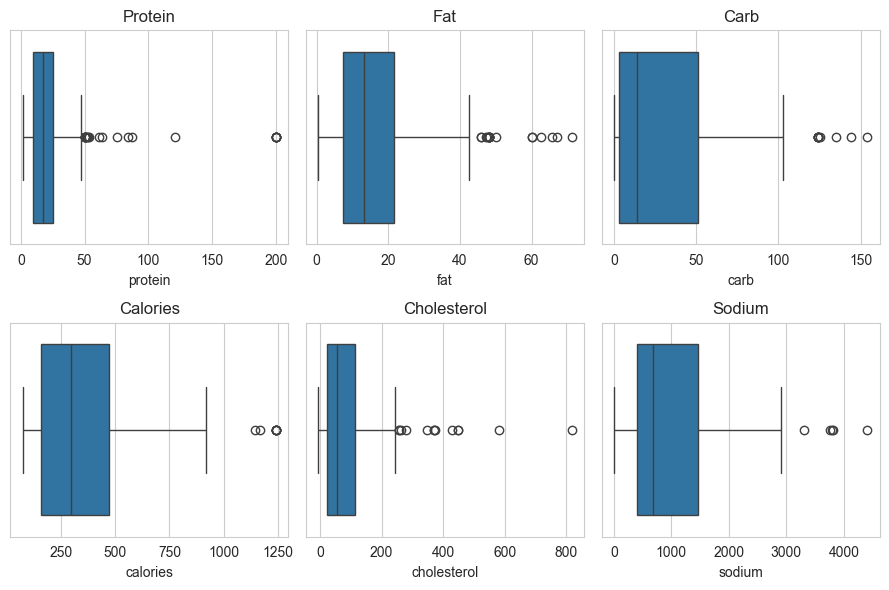

In [10]:
sns.set_style("whitegrid")

# Define the list of columns to plot
columns_to_plot = ['protein', 'fat', 'carb', 'calories', 'cholesterol', 'sodium']

# Box plots to identify outliers
plt.figure(figsize=(9, 6))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_food[column])
    plt.title(column.capitalize())

plt.tight_layout()
plt.show()

 These plots highlight the presence of outliers in the dataset, where values significantly higher than the rest can be observed. These outliers are meals with exceptionally high amounts of these nutrients. We will take a closer look.

In [11]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_dict = {}

for column in columns_to_plot:
    outliers_dict[column] = detect_outliers(df_food, column)

for column, outliers in outliers_dict.items():
    if not outliers.empty:
        print(f"{column} has {len(outliers)} outlier(s).")

# Combine all outliers into a single DataFrame, keeping unique rows only
all_outliers = pd.concat(outliers_dict.values()).drop_duplicates()

all_outliers

protein has 21 outlier(s).
fat has 17 outlier(s).
carb has 10 outlier(s).
calories has 8 outlier(s).
cholesterol has 13 outlier(s).
sodium has 5 outlier(s).


,food_name,protein,fat,carb,calories,cholesterol,sodium,cuisine
4,Assam prawn,52.64,20.69,10.78,327.56,232.74,1810.20,malay
31,Black pepper crab,50.54,16.68,0.00,351.12,234.08,2378.04,chinese
32,Boiled clams with shells,120.74,4.64,5.42,541.80,224.46,1656.36,chinese
33,Boiled kampung chicken,75.03,10.82,0.00,396.06,230.50,62.16,chinese
37,Braised duck without skin,61.53,14.43,0.00,375.97,279.25,788.64,chinese
58,Chicken Masala,87.00,50.00,16.00,860.00,255.00,2330.00,indian
60,Chicken Rice,200.00,48.22,124.00,1240.00,100.00,500.00,chinese
64,"Chicken wing, with liver and gizzard, braised",52.04,42.42,4.53,610.91,429.90,837.18,chinese
65,"Chicken, fried",84.06,6.72,1.13,99.28,31.21,202.68,western
66,"Chicken, roasted, skinless",53.13,14.75,0.00,345.42,199.98,553.48,chinese


We see that these outliers are valid items and we will keep them. 

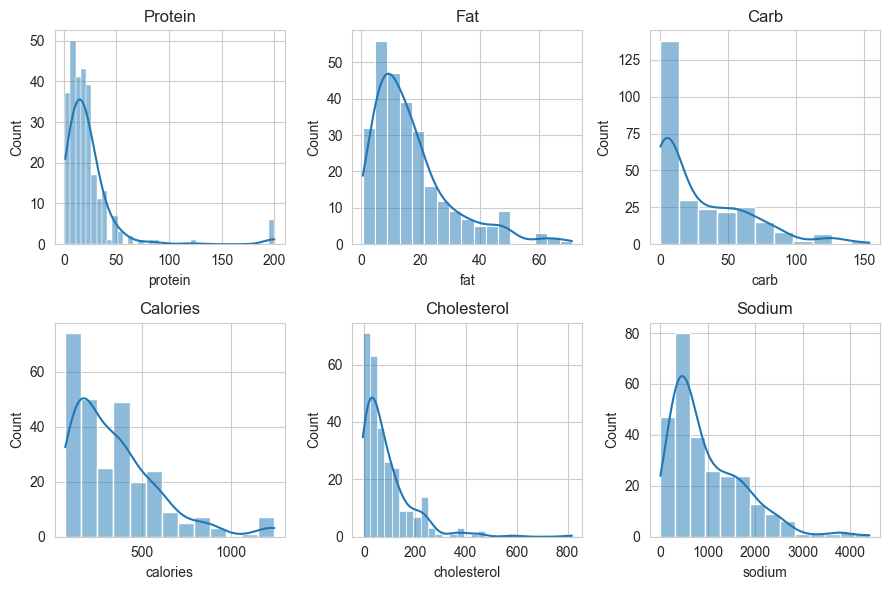

In [12]:
plt.figure(figsize=(9, 6))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_food[column], kde=True)
    plt.title(column.capitalize())

plt.tight_layout()
plt.show()

They show the distribution of values for protein, fat, carbohydrates, calories, cholesterol, and sodium. Most distributions appear right-skewed, indicating that a majority of the meals are clustered around the lower range of values, with fewer meals having very high nutritional values.

### **4. Development of Recommender**

Define an example profile of interest here to demonstrate the development of the recommendation model. This is a profile of a user, based on user particulars and health risk of chronic disease (output of the Prediction Model). The profile is used to pull out the dietary category for person fitting the profile

The profile developed will be for a Male, aged 51 to 59, low physical activity level with a high risk of chronic disease. 

In [13]:
profile_cat = "51 - 59MaleLow1"
profile = pd.DataFrame(df_diet[df_diet["food_name"]== profile_cat])

Merge profile with food dataset to develop cosine similarity matrix so that we can find the most similar profiles. 

In [14]:
merged_df = pd.concat([df_food, profile], axis = 0)

Verify that row is correctly added

In [15]:
merged_df.tail()
new_merged_df = merged_df.reset_index(inplace = False).drop(columns = "index")

In [16]:
new_merged_df.tail()

,food_name,protein,fat,carb,calories,cholesterol,sodium,cuisine
270,Yakitori chicken,4.66,11.20,3.01,131.25,47.64,210.70,others
271,Yakitori chicken ball,11.28,8.04,6.24,142.20,46.98,312.60,others
272,Yam rice,8.25,4.00,74.00,366.28,2.50,1025.00,chinese
273,Yu sheng,18.58,42.18,26.70,561.15,23.22,650.16,chinese
274,51 - 59MaleLow1,50.98,22.66,58.27,582.67,66.67,433.33,NaN


We see row 274 is correctly added. 

For analysis purpose, we will drop the "cuisine" column. We need to incorporate it in our streamlit application as it is part of the intended feature to allow users to select their preferred cuisine type. 

In [17]:
new_merged_df = new_merged_df.drop(columns = "cuisine") 

Perform standard scaling as the values are not on the same scale. Example: calories and protein.

Standard scaling ensures each nutritional attribute has a mean of zero and a standard deviation of one.
This normalization process is crucial for cosine similarity-based recommendation systems.
It guarantees that nutritional features are comparably scaled, allowing accurate calculation of cosine similarities between food items.
Moreover, standard scaling aids in discerning the relative importance of nutritional attributes in cosine similarity computations.
It highlights influential factors for more precise recommendations.
By preventing differences in nutritional values from dominating cosine distance calculations, standard scaling fosters balanced and accurate recommendations.
Additionally, it fosters model stability by curbing numerical instabilities.
This ensures smoother convergence in training cosine similarity-based recommendation algorithms.
Overall, standard scaling enhances cosine similarity-based recommendation systems.
It optimizes performance, accuracy, and stability for more meaningful and relevant food recommendations.

In [18]:
merged_df_name = new_merged_df["food_name"]
merged_df_sc = new_merged_df.copy()
merged_df_sc = merged_df_sc.set_index(new_merged_df.columns[0])
merged_df_new_columns = merged_df_sc.columns
sc = StandardScaler()
merged_df_sc = sc.fit_transform(merged_df_sc)
merged_df_sc = pd.DataFrame(merged_df_sc)
merged_df_sc = pd.concat([merged_df_name, merged_df_sc], axis=1)
merged_df_sc  = merged_df_sc.set_index(merged_df_sc.columns[0])
merged_df_sc.columns = merged_df_new_columns

Perform mean_centering.
This preprocessing technique is crucial in recommender systems, ensuring fairness and comparability across users or items.   
By subtracting each row's mean from its values, bias is minimized, allowing the system to focus on relative differences in item ratings or relative nutritional proportion for the case of our recommender.   

In [19]:
merged_df_sc_mc = mean_center_rows(merged_df_sc)

Calculates the cosine similarity matrix for the standardized and mean-centered dataset merged_df_sc_mc. `Cosine similarity` is a metric used to measure the similarity between two vectors by calculating the cosine of the angle between them.   

In this context, each row of the dataset represents a food item, and the cosine similarity is computed between pairs of food items based on their standardized and mean-centered nutritional attributes.  

The resulting `sim_matrix` is a square matrix where each element represents the cosine similarity between the corresponding pair of food items.   
This matrix captures the pairwise similarities between all food items in the dataset.  

The `food_sim` DataFrame is created using the sim_matrix, where the rows and columns represent food items, and the values indicate their cosine similarities.   
This DataFrame provides a comprehensive overview of the similarity relationships between all food items in the dataset.  

The cosine similarity values range from -1 to 1, where a value close to 1 indicates a high degree of similarity between two food items, while a value close to -1 indicates dissimilarity. A value of 0 suggests no similarity between the food items.  
  
`Food_sim` provide valuable insights into the pairwise similarity relationships between food items, enabling the identification of similar food items based on their nutritional attributes. This information can be utilized in recommendation systems to suggest relevant food items to users based on their preferences or dietary requirements.  

In [20]:
sim_matrix = cosine_similarity(merged_df_sc_mc)
food_sim = pd.DataFrame(sim_matrix, columns=merged_df_name, index=merged_df_name)

In [21]:
food_sim.head()

food_name,"Abalone noodles, soup","Anchovy, dried, with peanut, fried",Assam fish,Assam petai (Malay),Assam prawn,Ayam Goreng,Ayam kurmah,Ayam Masak Lemak Cili Padi,Ayam masak merah,Ayam tempra,...,Vegetarian brown rice porridge,Wanton Noodles,Wanton soup,Wonton Mee - Dry,Wonton Mee - Soup,Yakitori chicken,Yakitori chicken ball,Yam rice,Yu sheng,51 - 59MaleLow1
food_name,,,,,,,,,,,,,,,,,,,,,
"Abalone noodles, soup",1.000000,-0.131091,0.202852,-0.156374,0.110803,-0.524835,-0.671354,-0.860902,-0.549303,-0.734379,...,0.901168,-0.422461,0.777971,0.804042,0.980490,-0.764191,-0.395433,0.573816,-0.658852,-0.448378
"Anchovy, dried, with peanut, fried",-0.131091,1.000000,-0.285175,-0.351215,0.230662,-0.156082,0.628063,0.590786,-0.298084,0.160865,...,-0.336629,-0.358462,0.485638,-0.211601,-0.061338,-0.029707,-0.388273,-0.577523,0.588549,-0.359919
Assam fish,0.202852,-0.285175,1.000000,0.786455,0.783303,0.710521,-0.722691,-0.175513,0.644093,0.411103,...,-0.079923,-0.232420,-0.062334,-0.341086,0.027951,0.256917,0.739501,-0.334457,-0.725888,-0.232918
Assam petai (Malay),-0.156374,-0.351215,0.786455,1.000000,0.504014,0.864624,-0.420134,0.102185,0.893515,0.531696,...,-0.249934,0.049481,-0.403220,-0.519481,-0.300603,0.642707,0.938302,-0.344042,-0.385067,0.057609
Assam prawn,0.110803,0.230662,0.783303,0.504014,1.000000,0.568689,-0.420829,0.132383,0.428473,0.584569,...,-0.296303,-0.686829,0.249501,-0.489933,-0.050997,0.335058,0.510977,-0.674318,-0.476436,-0.681184


The cosine similarity values range from -1 to 1, where a value close to 1 indicates a high degree of similarity between two food items, while a value close to -1 indicates dissimilarity. A value of 0 suggests no similarity between the food items.  
  
`Food_sim` provide valuable insights into the pairwise similarity relationships between food items, enabling the identification of similar food items based on their nutritional attributes. This information can be utilized in recommendation systems to suggest relevant food items to users based on their preferences or dietary requirements.  

We have created a consine similarity matrix where we can find the most similar dish in nutrition value compared to our meal requirements

In [22]:
# print out top 10 food for profile_cat 
# food_sim.loc to select the column, drop the row with profile_cat and sort the values from the highest to lowest (thus, ascending = False)

profile_sim_withother = pd.DataFrame(food_sim.loc[profile_cat]).drop(index = profile_cat).sort_values(by = profile_cat, ascending = False) 
profile_sim_withother.reset_index(inplace = True)
for each_food in profile_sim_withother["food_name"].head(10).values:
    print(each_food)


Fish Soup Noodle
Wanton Noodles
Kway Teow Soup
Herbal Tonic Soup
Kebab, beef, without sauce
chicken kebab
Chicken Rice 
Seafood claypot noodles
Minced Pork Noodle - Dry 
Dry chicken feet noodles


### **5. Create Single Function**

Here we create a single function for the development of our streamlit app

In [23]:
def recommender_food(user_profile):

    def mean_center_rows(data):
        data = data.copy()
        data['avg_rating'] = data.mean(axis=1)
        
        for col in data.columns:
            data[col] = data[col] - data['avg_rating']
        
        data = data.drop(columns=['avg_rating'])
        data = data.fillna(0)

        return data
        
    def user_profile_mapping(user_profile):
        if user_profile["age"] in [1,2]:
            profile_cat = "18 - 29"
        elif user_profile["age"] in [3,4,5,6]:
            profile_cat = "30 - 50"
        elif user_profile["age"] in [7,8]:
            profile_cat = "51 - 59"
        else:
            profile_cat = "> 60"

        if user_profile["sex"]  == 1:
            profile_cat += "Male"
        else:
            profile_cat += "Female"
                
        if user_profile["exercise_cat"]  == 0:
            profile_cat += "Low"
        
        elif user_profile["exercise_cat"] == 1:
            profile_cat += "Moderate"
        else:
           profile_cat += "Active"
        
        if user_profile["CD"]  == 0:
           profile_cat += "0"
        else:
           profile_cat += "1"
           
        return profile_cat

    food_set = '../data/food_data_v3.csv'
    df_food = pd.read_csv(food_set)
    df_food = df_food[df_food["cuisine"] == user_profile["cuisine"]]
    diet_set = '../data/category_diet_v3.csv'
    df_diet = pd.read_csv(diet_set)
    profile_cat = user_profile_mapping(user_profile)
    profile = pd.DataFrame(df_diet[df_diet["food_name"]== profile_cat])
    merged_df = pd.concat([df_food, profile], axis = 0)
    merged_df = merged_df.drop(columns = "cuisine")
    new_merged_df = merged_df.reset_index(inplace = False).drop(columns = "index")
    merged_df_name = new_merged_df["food_name"]
    merged_df_sc = new_merged_df.copy()
    merged_df_sc = merged_df_sc.set_index(new_merged_df.columns[0])
    merged_df_new_columns = merged_df_sc.columns
    sc = StandardScaler()
    merged_df_sc = sc.fit_transform(merged_df_sc)
    merged_df_sc = pd.DataFrame(merged_df_sc)
    merged_df_sc = pd.concat([merged_df_name, merged_df_sc], axis=1)
    merged_df_sc  = merged_df_sc.set_index(merged_df_sc.columns[0])
    merged_df_sc.columns = merged_df_new_columns
    merged_df_sc_mc = mean_center_rows(merged_df_sc)
    sim_matrix = cosine_similarity(merged_df_sc_mc)
    food_sim = pd.DataFrame(sim_matrix, columns=merged_df_name, index=merged_df_name)
    profile_sim_withother = pd.DataFrame(food_sim.loc[profile_cat]).drop(index = profile_cat).sort_values(by = profile_cat, ascending = False) 
    profile_sim_withother.reset_index(inplace = True)
    return  profile_sim_withother["food_name"].head(10).values


### **6. Evaluation and Next Steps**

We tested out recommendation with two extremes of the spectrum.
One for an old lady who is inactive at a high risk of chronic diseases and the other who is a young active male who is at a low risk of chronic diseases. 

Profile 1: Old lady who is inactive at a high risk of chronic diseases

In [24]:
# old female inactive with chronic disease

user_profile = {
   "age": 13,
   "sex": 0,
   "exercise_cat": 0,
   "CD": 1,
   "cuisine": "chinese"
}

recommender_food(user_profile)

array(['Herbal Tonic Soup', 'Wanton Noodles', 'Fish Soup Noodle',
       'Kway Teow Soup', 'Minced Pork Noodle - Dry ',
       'Duck rice, with skin removed', 'Chicken Rice ',
       'Seafood claypot noodles', 'Dry chicken feet noodles',
       'Duck Rice - skin removed '], dtype=object)

Profile 2: Young active male who is at a low risk of chronic diseases. 

In [25]:
# young male active with no chronic disease

user_profile = {
   "age": 1,
   "sex": 1,
   "exercise_cat": 2,
   "CD": 0,
   "cuisine": "chinese"
}

recommender_food(user_profile)

array(['Duck Rice - skin removed ', 'Minced Pork Noodle - Dry ',
       'Chicken Rice ', 'Dry chicken feet noodles',
       'Duck rice, with skin removed', 'Seafood claypot noodles',
       'Fish Soup Noodle', 'Wanton Noodles', 'Kway Teow Soup',
       'Herbal Tonic Soup'], dtype=object)

Evaluating the recommender system's suggestions for two distinct profiles yields some insights into its effectiveness and areas for improvement:

**Profile 1: Old Lady Who Is Inactive at a High Risk of Chronic Diseases**  
Suitability: Meals like "Macaroni soup" and "Boiled kampung chicken" seem appropriate due to their potential for healthy preparation. However, "Beef, spicy, stir fried" may not be ideal due to higher fat and sodium content.  
Variety and Specific Needs: The variety is commendable, but the inclusion of fried and spicy items could contradict dietary recommendations for this profile, emphasizing the need for low-fat and low-sodium options.  
**Profile 2: Young Active Male Who Is at a Low Risk of Chronic Diseases**    
Suitability: The selection matches the higher energy needs of an active lifestyle, with choices like "Beef, spicy, stir fried" providing necessary proteins and calories.  
Variety and Specific Needs: The range of protein sources and cooking methods is suitable, though ensuring these meals are part of a balanced diet with vegetables and whole grains would be beneficial.  
  
**Overall Evaluation**  
Overlap in Recommendations: The presence of common meals across profiles suggests a baseline of balanced options, though the specifics of each profile's dietary needs could be better addressed.    
Customization and Nutritional Balance: The system demonstrates an attempt at customization, but could further improve by tailoring more closely to the health and activity specifics of each profile, ensuring balanced and nutritious meal suggestions.  

**Recommendations for Improvement**  
Personalization: Integrate finer dietary preferences, nutrition information for dishes and restrictions, particularly for health-related needs.   
Health Considerations: Avoid ingredients unsuitable for specific health conditions, and focus on heart-healthy, nutrient-rich foods.  
Completeness: Advise on portion sizes and preparation methods to ensure nutritional balance.    
In summary, while the recommender system shows promise by considering different dietary needs, refining its customization and balancing nutritional aspects could enhance its utility and effectiveness.    